# Time Series on HPC

## Kernel installation

- Run the following line (script) once, if the required kernel (big-data-dda-kernel) is not installed.
- You need to install this kernel only once

In [ ]:
%%bash
mkdir -p ~/.local/share/jupyter/kernels/ai4seismology-bigdata
cp /data/horse/ws/s4122485-ai4seismology_dev/thursday_bigdata/kernel.json ~/.local/share/jupyter/kernels/ai4seismology-bigdata

### Important!!!
Once the Kernel is installed, 
1. Reload the notebook (reload/refresh the web page)
2. Select the kernel: Menu -> Kernel -> Change Kernel -> Select "dda-kernel"
Always use this kernel for upcoming exercises.

## Select ai4seismology-bigdata kernel

In [ ]:
import sys

In [ ]:
!{sys.executable} -m pip install --user --upgrade ipympl jupyter_leaflet leafmap ipyleaflet

## Data Processing

### Start Spark Standalone Cluster

In [1]:
# Import utilities required to run big data frameworks on ZIH HPC systems
from big_data_utils.environment_utils import ClusterConfig
from big_data_utils.cluster_utils import ClusterService


In [2]:
# Configure the cluster environment
myconfig = ClusterConfig(fw_name="spark")
myconfig.configure_env(conf_dest="./my-conf",randomize_ports=True)

[INFO ] [08/05/2025 10:52:20] - Removing existing configuration directory: './my-conf'
[INFO ] [08/05/2025 10:52:21] - Environment configuration initialized:
[INFO ] [08/05/2025 10:52:21] -   • Framework:        SPARK
[INFO ] [08/05/2025 10:52:21] -   • Config template:  /software/rapids/r24.04/Spark/3.5.0-GCC-13.2.0-hadoop3/conf
[INFO ] [08/05/2025 10:52:21] -   • Config target:    ./my-conf
[INFO ] [08/05/2025 10:52:21] -   • Log directory:    ./my-conf/log
[INFO ] [08/05/2025 10:52:21] - Initializing configuration from template.
[INFO ] [08/05/2025 10:52:23] - Cluster topology:
[INFO ] [08/05/2025 10:52:23] -   • Master node:  n1042:7904
[INFO ] [08/05/2025 10:52:23] -   • Worker nodes: n1042
[INFO ] [08/05/2025 10:52:23] -   • Spark master URL: spark://n1042:7904
[INFO ] [08/05/2025 10:52:23] - Once the cluster is started, one can access the spark GUI in browser using port forwarding.
[INFO ] [08/05/2025 10:52:23] - To access, spark GUI, type following in your terminal on local mac

In [3]:
# Initialize the cluster service class
mycluster = ClusterService("spark")

# Check which java processes are running
mycluster.check_status()

[INFO ] [08/05/2025 10:52:26] - Currently, following java processes are running:
[INFO ] [08/05/2025 10:52:26] - 	Process ID, Name 


In [4]:
# Start Spark standalone cluster
mycluster.start_cluster()

[INFO ] [08/05/2025 10:52:31] - Starting SPARK cluster.
[INFO ] [08/05/2025 10:52:37] - Logging cluster startup info at: ./my-conf/spark/log/cluster.log

----Performance Data----
Duration: 5.41

CPU Util (Across CPUs)       	AVG: 40.08	 MIN: 0.00	 MAX: 100.00
Mem Util in GB (Across nodes)	AVG: 215.77	 MIN: 215.61	 MAX: 215.95
IO Ops (excl.) Read          	Total: 25004
               Write         	Total: 3718
IO Bytes (excl.) Read        	Total: 101.08
                 Write       	Total: 0.64


In [5]:
# Check if the master and worker processes are started or not
mycluster.check_status()

[INFO ] [08/05/2025 10:52:39] - Currently, following java processes are running:
[INFO ] [08/05/2025 10:52:39] - 	Process ID, Name 
[INFO ] [08/05/2025 10:52:39] - 	2875051, Master
[INFO ] [08/05/2025 10:52:39] - 	2875137, Worker


### Spark context initialization

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from glob import glob
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, TimestampType
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# Create spark session
spark = SparkSession.builder \
                    .master(f"spark://{myconfig.get_master_host()}:{myconfig.get_master_port()}") \
                    .appName("TimeSeriesAnalysis") \
                    .getOrCreate()
sc = spark.sparkContext


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/08 10:52:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



----Performance Data----
Duration: 4.82

CPU Util (Across CPUs)       	AVG: 28.81	 MIN: 0.00	 MAX: 100.00
Mem Util in GB (Across nodes)	AVG: 216.19	 MIN: 216.05	 MAX: 216.33
IO Ops (excl.) Read          	Total: 27276
               Write         	Total: 3833
IO Bytes (excl.) Read        	Total: 129.13
                 Write       	Total: 0.73


### Data loading

The following data contain measurements of power consumption (unit: watts) and temperature (unit: °C) of CPUs on the HPC cluster of TU Dresden. 
Every single CPU is identified by its socket_id.

In [8]:
df = spark.read.parquet("/data/horse/ws/s4122485-ai4seismology/big_data/2025-04-21-2025-04-25timestamp-socket_id-power_sum-temperature3113440779630811.parquet")


----Performance Data----
Duration: 5.08

CPU Util (Across CPUs)       	AVG: 43.62	 MIN: 18.10	 MAX: 100.00
Mem Util in GB (Across nodes)	AVG: 217.03	 MIN: 216.95	 MAX: 217.11
IO Ops (excl.) Read          	Total: 27549
               Write         	Total: 3870
IO Bytes (excl.) Read        	Total: 131.33
                 Write       	Total: 0.77


In [9]:
df.printSchema()
df.show()
print(f"Number of rows {df.count()}")

root
 |-- timestamp: string (nullable = true)
 |-- socket_id: long (nullable = true)
 |-- power_sum: double (nullable = true)
 |-- temperature: double (nullable = true)



+-------------------+---------+---------+-----------+
|          timestamp|socket_id|power_sum|temperature|
+-------------------+---------+---------+-----------+
|2025-04-22 00:12:58|     6977|    140.0|      52.86|
|2025-04-22 00:02:32|     6977|    140.0|     52.954|
|2025-04-22 00:02:17|     6977|    140.0|     52.704|
|2025-04-22 00:04:24|     6977|    140.0|     52.922|
|2025-04-22 00:24:57|     6977|    138.0|     53.094|
|2025-04-22 00:20:44|     6977|    140.0|     53.079|
|2025-04-22 00:19:58|     6977|    140.0|     53.219|
|2025-04-22 00:25:10|     6977|    140.0|     53.094|
|2025-04-22 00:04:50|     6977|    139.0|     52.579|
|2025-04-22 00:21:35|     6977|    139.0|      52.75|
|2025-04-22 00:01:57|     6977|    140.0|     52.813|
|2025-04-22 00:11:32|     6977|    139.0|     52.938|
|2025-04-22 00:07:20|     6977|    140.0|     52.672|
|2025-04-22 00:25:12|     6977|    139.0|     53.094|
|2025-04-22 00:09:49|     6977|    140.0|     52.719|
|2025-04-22 00:02:38|     69

### Basic cleaning and data summary

In [10]:
# set meaningful data types
df = df \
    .withColumn("timestamp", df.timestamp.cast(TimestampType())) \
    .withColumn("temperature", df.temperature.cast(FloatType())) \
    .withColumn("power_sum", df.power_sum.cast(FloatType())) \
    .withColumn("socket_id", df.socket_id.cast(StringType())) \
    .orderBy("timestamp")
df.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- socket_id: string (nullable = true)
 |-- power_sum: float (nullable = true)
 |-- temperature: float (nullable = true)



In [11]:
# getting summary statistics
# hint: The summary function tries to interpret strings as numbers.
df.summary().show()

25/05/08 10:56:17 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+
|summary|         socket_id|         power_sum|       temperature|
+-------+------------------+------------------+------------------+
|  count|            861970|            861970|            861970|
|   mean|            6977.5|123.43936679930856|52.821822555181576|
| stddev|0.5000002900335522|26.089912860755167| 4.227714869610159|
|    min|              6977|              29.0|            40.954|
|    25%|            6977.0|             118.0|            51.344|
|    50%|            6978.0|             135.0|            53.032|
|    75%|            6978.0|             140.0|            54.829|
|    max|              6978|             200.0|             66.61|
+-------+------------------+------------------+------------------+


----Performance Data----
Duration: 6.39

CPU Util (Across CPUs)       	AVG: 44.52	 MIN: 7.00	 MAX: 85.70
Mem Util in GB (Across nodes)	AVG: 217.70	 MIN: 217.61	 MAX: 217.83
IO Ops (excl.) Read  

In [12]:
# socket_id is a categorical column, check unique values
df.select("socket_id").distinct().show()

+---------+
|socket_id|
+---------+
|     6978|
|     6977|
+---------+



In [13]:
# count number of observations per group
df.groupBy("socket_id").count()  # Physical plan (no repartition)
print("Partitions (original df):", df.rdd.getNumPartitions())
df.groupBy("socket_id").agg(
    F.count("temperature").alias("temp_count_per_socket"),
    F.mean("temperature").alias("mean_temp_socket")
).show()

Partitions (original df): 4


+---------+---------------------+-----------------+
|socket_id|temp_count_per_socket| mean_temp_socket|
+---------+---------------------+-----------------+
|     6978|               430985|51.69739268016241|
|     6977|               430985|53.94625243020074|
+---------+---------------------+-----------------+



### Data reduction using resampling

For easier handling of big data volumes, data reduction is essential. 
One common approach is subsampling, as it allows prototyping/developing the operations of interest and plotting.

In [15]:
# Step 1: Get all distinct socket_ids and convert to python list
distinct_ids = df.select("socket_id").distinct().rdd.flatMap(lambda x: x).collect()
print(f'type of dinstinct_ids: {type(distinct_ids)}')

# Step 2: Assign the same fraction (e.g., 10%) to each ID
sampling_fraction = 0.005
fractions = {id_: sampling_fraction for id_ in distinct_ids}

# Step 3: Perform sampling per socket_id
sampled = df.sampleBy("socket_id", fractions, seed=42)
sampled.show()

type of dinstinct_ids: <class 'list'>
+-------------------+---------+---------+-----------+
|          timestamp|socket_id|power_sum|temperature|
+-------------------+---------+---------+-----------+
|2025-04-21 00:02:07|     6978|    154.0|     52.438|
|2025-04-21 00:02:36|     6978|    146.0|     52.266|
|2025-04-21 00:09:59|     6978|    145.0|     52.454|
|2025-04-21 00:10:04|     6977|    141.0|     52.657|
|2025-04-21 00:11:42|     6978|    147.0|     52.469|
|2025-04-21 00:13:41|     6978|     88.0|      50.25|
|2025-04-21 00:14:05|     6978|    155.0|     52.219|
|2025-04-21 00:15:12|     6977|    139.0|     52.375|
|2025-04-21 00:17:29|     6978|    161.0|     52.485|
|2025-04-21 00:19:49|     6978|    107.0|     52.516|
|2025-04-21 00:21:20|     6977|    149.0|       52.5|
|2025-04-21 00:23:54|     6977|    146.0|     52.157|
|2025-04-21 00:27:16|     6978|    155.0|     52.313|
|2025-04-21 00:28:07|     6977|    145.0|       52.5|
|2025-04-21 00:30:18|     6978|    146.0|   

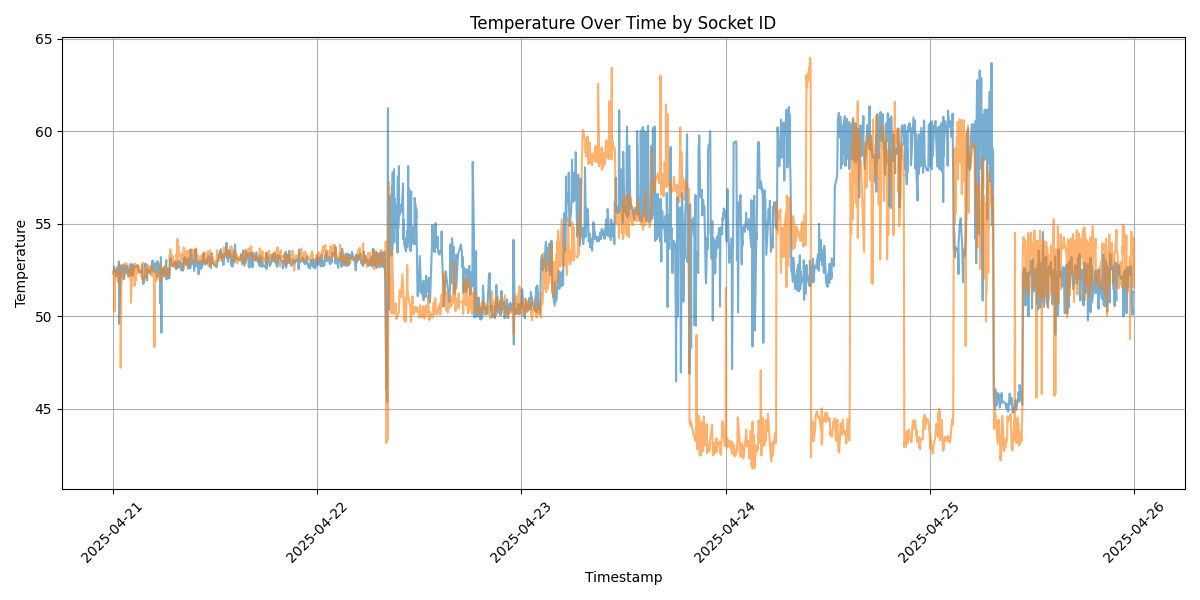

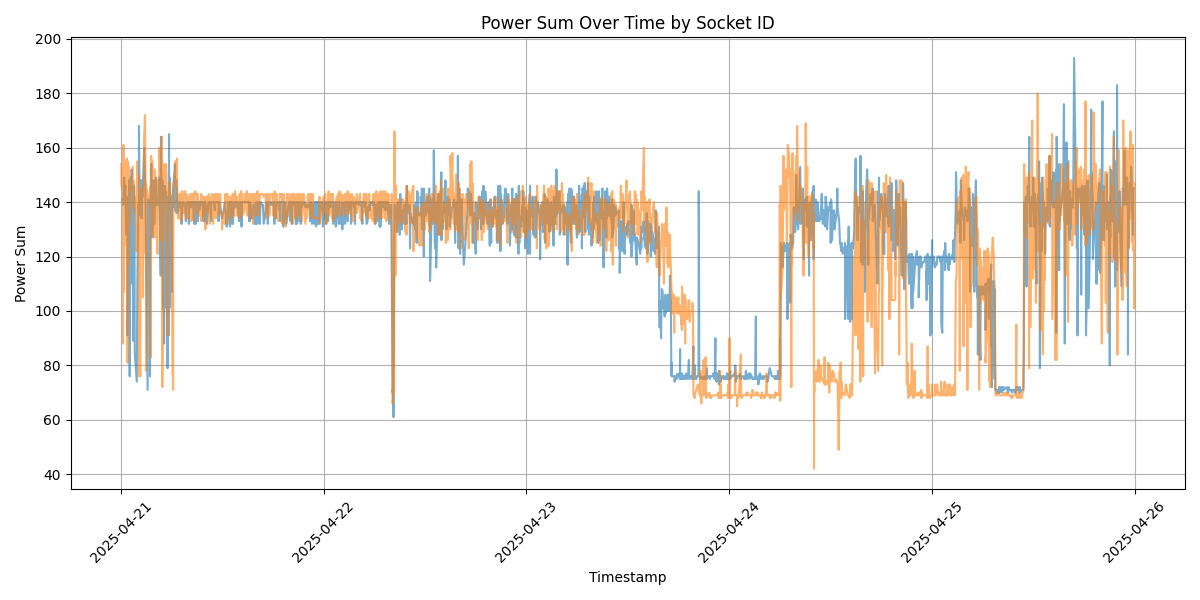


----Performance Data----
Duration: 5.32

CPU Util (Across CPUs)       	AVG: 11.32	 MIN: 0.00	 MAX: 38.20
Mem Util in GB (Across nodes)	AVG: 218.19	 MIN: 218.15	 MAX: 218.22
IO Ops (excl.) Read          	Total: 29600
               Write         	Total: 4200
IO Bytes (excl.) Read        	Total: 188.62
                 Write       	Total: 1.06


In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Collect and prepare
pdf = sampled.select("timestamp", "temperature", "power_sum", "socket_id").toPandas()
pdf["timestamp"] = pd.to_datetime(pdf["timestamp"])
pdf = pdf.sort_values(["socket_id", "timestamp"])

# --------- Plot 1: Temperature ---------
plt.figure(figsize=(12, 6))
for socket_id, group in pdf.groupby("socket_id"):
    plt.plot(group["timestamp"], group["temperature"], label=f"Socket {socket_id}", alpha=0.6)
plt.title("Temperature Over Time by Socket ID")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Socket ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# --------- Plot 2: Power Sum ---------
plt.figure(figsize=(12, 6))
for socket_id, group in pdf.groupby("socket_id"):
    plt.plot(group["timestamp"], group["power_sum"], label=f"Socket {socket_id}", alpha=0.6)
plt.title("Power Sum Over Time by Socket ID")
plt.xlabel("Timestamp")
plt.ylabel("Power Sum")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Socket ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


### Moving average calculation

In [ ]:
# getting number of observations per hour to determine the order of the moving average
df = df.withColumn("hour", F.date_trunc("hour", "timestamp"))

obs_per_hour = df.groupBy("hour").agg(F.count("*").alias("count_per_hour"))
obs_per_hour.orderBy("hour").show()
mean_obs = obs_per_hour.agg(F.mean("count_per_hour").alias("avg_obs_per_hour"))
avg_obs_per_hour = int(mean_obs.collect()[0]["avg_obs_per_hour"])
print(f'average number of counts per hour: {avg_obs_per_hour}')                            

In [ ]:
ma_order = avg_obs_per_hour  # Moving average order

# Define window: partition by ID, order by time, look back k-1 rows
window_spec = (
    Window
    .partitionBy("socket_id")
    .orderBy("timestamp")
    .rowsBetween(-ma_order + 1, 0)
)

# Add moving average column
df = df.withColumn("temperature_ma", F.avg("temperature").over(window_spec))

In [ ]:
df.show()

In [ ]:
# Step 1: Get all distinct socket_ids and convert to python list
distinct_ids = df.select("socket_id").distinct().rdd.flatMap(lambda x: x).collect()
print(f'type of dinstinct_ids: {type(distinct_ids)}')

# Step 2: Assign the same fraction (e.g., 10%) to each ID
sampling_fraction = 0.005
fractions = {id_: sampling_fraction for id_ in distinct_ids}

# Step 3: Perform sampling per socket_id
sampled = df.sampleBy("socket_id", fractions, seed=42)
sampled.show()

In [ ]:
# Collect and prepare
pdf = sampled.select("timestamp", "temperature", "temperature_ma", "socket_id").toPandas()
pdf["timestamp"] = pd.to_datetime(pdf["timestamp"])
pdf = pdf.sort_values(["socket_id", "timestamp"])

In [ ]:
plt.figure(figsize=(12, 6))

# Loop through each socket_id group
for socket_id, group in pdf.groupby("socket_id"):
    # Plot raw temperature
    plt.plot(group["timestamp"], group["temperature"],
             label=f"Socket {socket_id} (Raw)", alpha=0.4)
    
    # Plot moving average
    plt.plot(group["timestamp"], group["temperature_ma"],
             label=f"Socket {socket_id} (MA)", linewidth=2)

plt.title("Temperature Over Time with Moving Average by Socket ID")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Socket ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

### Lazy Evaluation: Transformation vs. Action

In [17]:
%%time
# Groupwise summary: mean temperature per socket
# this is a lazy operation
grouped_df = df.groupBy("socket_id").agg(F.mean("temperature").alias("mean_temperature"))


CPU times: user 927 μs, sys: 1.96 ms, total: 2.89 ms
Wall time: 18 ms


In [18]:
%%time
# actual computation is done here, as show() is an action
grouped_df.show()

+---------+-----------------+
|socket_id| mean_temperature|
+---------+-----------------+
|     6978|51.69739268016241|
|     6977|53.94625243020074|
+---------+-----------------+

CPU times: user 2.92 ms, sys: 11 ms, total: 13.9 ms
Wall time: 2.52 s


### Stop the Spark context and Spark standalone cluster

In [24]:
# Stopping spark context and checking the cluster status
sc.stop()
mycluster.stop_cluster()
mycluster.check_status()

[INFO ] [08/05/2025 10:51:42] - Stopping SPARK cluster.
[INFO ] [08/05/2025 10:51:46] - Logging cluster stopping info at: ./my-conf/spark/log/cluster.log
[INFO ] [08/05/2025 10:51:46] - Currently, following java processes are running:
[INFO ] [08/05/2025 10:51:46] - 	Process ID, Name 


In [25]:
# Sometimes the SparkSubmit process is not killed, and requires to be killed manually
mycluster.kill_cluster_processes()
mycluster.check_status()

[INFO ] [08/05/2025 10:51:49] - Killing SPARK cluster processes.
[INFO ] [08/05/2025 10:51:49] - Killing process SparkSubmit
[INFO ] [08/05/2025 10:51:49] - Killing process CoarseGrainedExecutorBackend
[INFO ] [08/05/2025 10:51:49] - Killing process Master
[INFO ] [08/05/2025 10:51:49] - Killing process Worker
[INFO ] [08/05/2025 10:51:49] - Cluster processes killed.
[INFO ] [08/05/2025 10:51:49] - Currently, following java processes are running:
[INFO ] [08/05/2025 10:51:49] - 	Process ID, Name 
